<a href="https://colab.research.google.com/github/IT22232236/fake-news-detection/blob/main/notebooks/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:

!git config --global user.email "it22232236@my.sliit.lk"
!git config --global user.name "IT22232236"


In [49]:
REPO = "fake-news-detection"
OWNER = "IT22232236"       # repo owner’s username (yours)
TOKEN = "token"

!git clone https://{TOKEN}@github.com/{OWNER}/{REPO}.git
%cd /content/{REPO}

fatal: destination path 'fake-news-detection' already exists and is not an empty directory.
/content/fake-news-detection


In [51]:
BRANCH = "feat/memberC-evaluation"
!git checkout -b {BRANCH}

fatal: A branch named 'feat/memberC-evaluation' already exists.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p results/models
!cp '/content/drive/MyDrive/fake_news_project/models/'* results/models/
print("✅ Models copied locally for Member D.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat '/content/drive/MyDrive/fake_news_project/models/*': No such file or directory
✅ Models copied locally for Member D.


In [56]:
import joblib, tensorflow as tf

# Define the correct base path in Google Drive
MODEL_DIR = "/content/drive/MyDrive/fake_news_project/models"

import re

def clean_text(t):
    """Cleans the input text for fake news detection."""
    t = t.lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-z\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# --- Classical Models ---
lr_model        = joblib.load(f"{MODEL_DIR}/logreg.joblib")
svm_model       = joblib.load(f"{MODEL_DIR}/svm.joblib")
tfidf_vectorizer= joblib.load(f"{MODEL_DIR}/tfidf_vectorizer.joblib")
tfidf_logreg    = joblib.load(f"{MODEL_DIR}/tfidf_logreg.joblib")

# --- Deep Learning Model ---
lstm_model      = tf.keras.models.load_model(f"{MODEL_DIR}/lstm.h5")
lstm_tokenizer  = joblib.load(f"{MODEL_DIR}/lstm_tokenizer.joblib")

print("✅ All 4 models and tokenizer loaded successfully!")


✅ All 4 models and tokenizer loaded successfully!


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_fake_news(text):
    """
    Predict Fake/Real using:
      1. TF-IDF + Logistic Regression
      2. SVM
      3. LSTM
    Returns each result and a majority-vote decision.
    """
    results = {}
    text_cleaned = clean_text(text)

    # --- 1. TF-IDF + Logistic Regression ---
    X_tfidf = tfidf_vectorizer.transform([text_cleaned])
    pred_tfidf = tfidf_logreg.predict(X_tfidf)[0]
    prob_tfidf = tfidf_logreg.predict_proba(X_tfidf)[0][pred_tfidf]
    results['TFIDF_LogReg'] = ('Fake' if pred_tfidf else 'Real', round(prob_tfidf, 3))

    # --- 2. SVM ---
    pred_svm = svm_model.predict(X_tfidf)[0]
    score = svm_model.decision_function(X_tfidf)[0]
    svm_conf = float(1 / (1 + np.exp(-abs(score))))   # pseudo-confidence
    results['SVM'] = ('Fake' if pred_svm else 'Real', round(svm_conf, 3))

    # --- 3. LSTM ---
    seq = lstm_tokenizer.texts_to_sequences([text_cleaned])
    pad = pad_sequences(seq, maxlen=300)
    prob_fake = float(lstm_model.predict(pad, verbose=0)[0][0])
    pred_lstm = 1 if prob_fake >= 0.5 else 0
    results['LSTM'] = ('Fake' if pred_lstm else 'Real', round(prob_fake, 3))

    # --- Majority Vote ---
    votes = [label for label, _ in results.values()]
    final = 'Fake' if votes.count('Fake') >= 2 else 'Real'
    results['Majority_Vote'] = (final, None)

    return results


In [55]:
news_text = input("Enter a news headline or paragraph:\n")
preds = predict_fake_news(news_text)

print("\n🧾 Prediction Results:")
for model, (label, prob) in preds.items():
    print(f"{model:15s}: {label}  (Confidence: {prob})")


Enter a news headline or paragraph:
Apple announces that the next iPhone will come with a built-in teleportation feature.

🧾 Prediction Results:
TFIDF_LogReg   : Fake  (Confidence: 0.754)
SVM            : Fake  (Confidence: 0.532)
LSTM           : Fake  (Confidence: 0.999)
Majority_Vote  : Fake  (Confidence: None)


In [26]:
news_text = input("Enter a news headline or paragraph:\n")
preds = predict_fake_news(news_text)

print("\n🧾 Prediction Results:")
for model, (label, prob) in preds.items():
    print(f"{model}: {label} (Confidence: {prob})")

Enter a news headline or paragraph:
Breaking: Scientists confirm aliens have built a base on the dark side of the moon!

🧾 Prediction Results:
TFIDF_LogReg: Fake (Confidence: 0.918)
SVM: Fake (Confidence: 0.569)
LSTM: Fake (Confidence: 0.997)
Majority_Vote: Fake (Confidence: None)


          Model  Accuracy        F1
0            LR  0.990421  0.990798
1           SVM  0.997550  0.997656
2  TFIDF_LogReg  0.990867  0.991234
3          LSTM  0.977723  0.978723


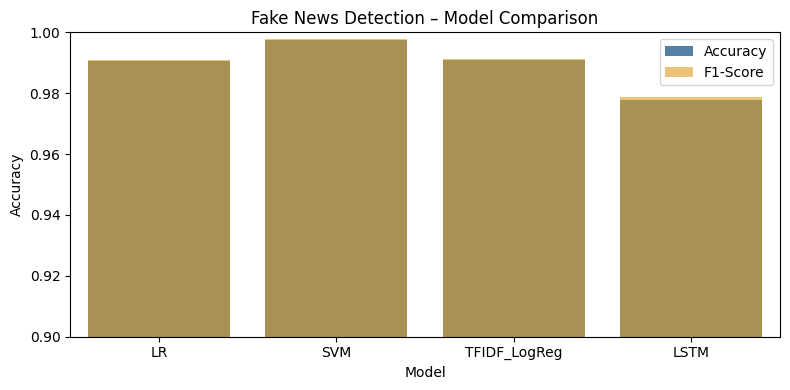

In [27]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

df = pd.read_csv('results/model_metrics.csv')
print(df)

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='Accuracy', data=df, color='steelblue', label='Accuracy')
sns.barplot(x='Model', y='F1', data=df, color='orange', alpha=0.6, label='F1-Score')
plt.title('Fake News Detection – Model Comparison')
plt.ylim(0.9,1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
!pip -q install streamlit==1.37.0 pyngrok==7.1.6
from google.colab import drive
drive.mount('/content/drive')

MODEL_DIR = "/content/drive/MyDrive/fake_news_project/models"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.15.1 requires watchdog<7.0.0,>=6.0.0, but you have watchdog 4.0.2 which is incompatible.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%%writefile app.py

import streamlit as st
st.set_page_config(page_title="Fake News Detection", page_icon="📰")

import re, joblib, numpy as np, tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --------- CONFIG ----------
MODEL_DIR = "/content/drive/MyDrive/fake_news_project/models"
MAX_LEN = 300
USE_LSTM = True     # set to False if you want only TF-IDF + SVM
# ---------------------------

# ---------- TEXT CLEANER ----------
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+", "", t)
    t = re.sub(r"[^a-z\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# ---------- LOAD MODELS ----------
@st.cache_resource
def load_models():
    tfidf = joblib.load(f"{MODEL_DIR}/tfidf_vectorizer.joblib")
    tfidf_lr = joblib.load(f"{MODEL_DIR}/tfidf_logreg.joblib")
    svm = joblib.load(f"{MODEL_DIR}/svm.joblib")

    lstm, tokenizer = None, None
    if USE_LSTM:
        lstm = tf.keras.models.load_model(f"{MODEL_DIR}/lstm.h5", compile=False)
        try:
            tokenizer = joblib.load(f"{MODEL_DIR}/lstm_tokenizer.joblib")
        except:
            tokenizer = None
            st.warning("Tokenizer for LSTM not found — skipping LSTM model.")
    return tfidf, tfidf_lr, svm, lstm, tokenizer


tfidf, tfidf_lr, svm, lstm, tokenizer = load_models()

# ---------- PAGE HEADER ----------
st.title("📰 Fake News Detection Dashboard")
st.markdown(
    "This tool analyzes a given news headline or short paragraph "
    "using multiple machine-learning models to determine whether it’s **real or fake news**."
)

user_text = st.text_area(
    "Enter a news headline or paragraph:",
    height=160,
    placeholder="e.g. Sri Lanka central bank announces new monetary policy adjustments for 2025"
)
run = st.button("🔍 Detect")

# ---------- HELPER ----------
def pseudo_confidence_from_decision(score: float) -> float:
    """Normalize SVM decision score to 0–1."""
    return float(1 / (1 + np.exp(-abs(score))))

# ---------- PREDICTION ----------
if run and user_text.strip():
    text_c = clean_text(user_text)
    results = []

    # --- TF-IDF + Logistic Regression ---
    X = tfidf.transform([text_c])
    pred_lr = int(tfidf_lr.predict(X)[0])
    prob_lr = float(tfidf_lr.predict_proba(X)[0][pred_lr])
    label_lr = "Fake" if pred_lr == 1 else "Real"
    results.append(("TFIDF + LogReg", label_lr, prob_lr))

    # --- SVM ---
    pred_svm = int(svm.predict(X)[0])
    score = float(svm.decision_function(X)[0])
    conf_svm = pseudo_confidence_from_decision(score)
    label_svm = "Fake" if pred_svm == 1 else "Real"
    results.append(("SVM", label_svm, conf_svm))

    # --- LSTM ---
    if USE_LSTM and tokenizer is not None and lstm is not None:
        seq = tokenizer.texts_to_sequences([text_c])
        pad = pad_sequences(seq, maxlen=MAX_LEN)
        prob_fake = float(lstm.predict(pad, verbose=0)[0][0])
        pred_lstm = 1 if prob_fake >= 0.5 else 0
        label_lstm = "Fake" if pred_lstm == 1 else "Real"
        results.append(("LSTM", label_lstm, prob_fake))

    # --- Majority Vote ---
    votes = [r[1] for r in results]
    final_label = "Fake" if votes.count("Fake") >= (len(votes)//2 + 1) else "Real"

    # ---------- DISPLAY RESULTS ----------
    st.subheader("Prediction Results")
    for name, label, conf in results:
        st.write(f"**{name}:** {label}  |  Confidence = `{conf:.3f}`")

    st.markdown("---")
    if final_label == "Fake":
        st.error(f"🧾 **Final Decision:** {final_label}")
    else:
        st.success(f"🧾 **Final Decision:** {final_label}")

    st.caption("*(Note: SVM confidence is a normalized margin, not a true probability.)*")

else:
    st.info("💡 Enter text above and click **Detect** to begin.")


Overwriting app.py


In [45]:
import os
os.environ["NGROK_API_KEY"] = "33rjDDywzSwxb5CEupbJm2bf4rn_7mXYrMmjva11ZQr8LW4RZ"


In [46]:
!pip -q install pyngrok==7.1.6

from pyngrok import ngrok
import subprocess, time, os

# If you have an ngrok API key, set it once; otherwise comment the next 2 lines.
NGROK_API_KEY = os.getenv("NGROK_API_KEY", None)
if not NGROK_API_KEY:
    print("If you have an ngrok API key, set it like this before running:")
    print("import os; os.environ['NGROK_API_KEY'] = 'YOUR_KEY_HERE'")

# Kill any previous tunnels
ngrok.kill()

# Start Streamlit
port = 8501
proc = subprocess.Popen(["streamlit", "run", "app.py",
                         "--server.port", str(port),
                         "--server.address", "0.0.0.0"])

# Give it a moment to boot
time.sleep(5)

# Open tunnel
if NGROK_API_KEY:
    ngrok.set_auth_token(NGROK_API_KEY)
public_url = ngrok.connect(port, "http").public_url
print("🔗 Public URL:", public_url)


🔗 Public URL: https://corie-araneose-van.ngrok-free.dev


In [ ]:
!git add app.py
!git commit -m "Member D – added Streamlit app.py for final deployment"
!git push --set-upstream origin feat/evaluation